## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera calibration is computed using chessboard images. 

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas 

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)


## Based on the image and object points, calibrate the camera and show an example of an undistorted image and the corrected image

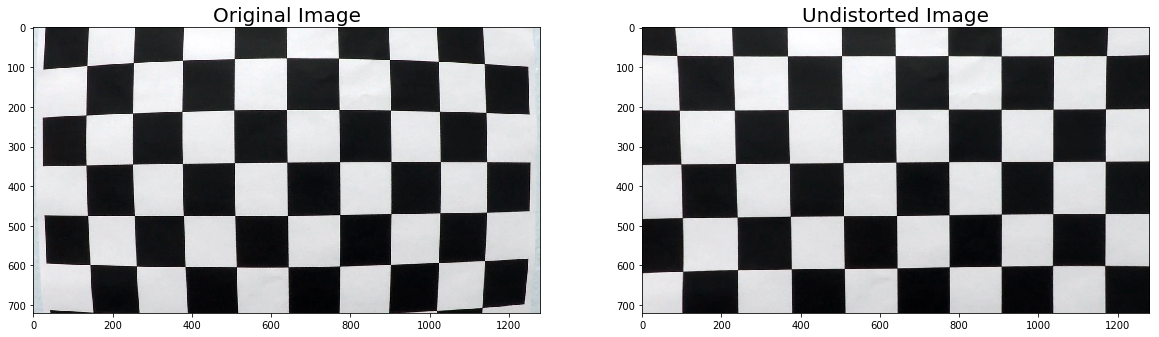

In [2]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)

## Global variables

In [3]:
debug=0

## Convert to the HLS color space, take the gradient, and apply thresholding on both gradient and the s-channel. Show the image result.

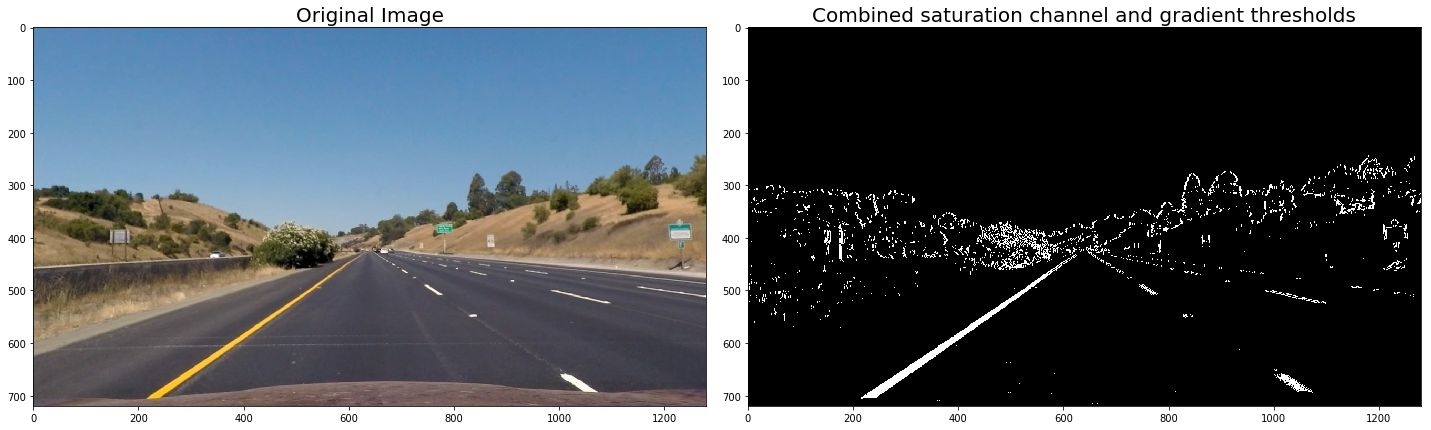

In [4]:
# Input:
#   File to apply gradient thresholding
#   Boolean option to plot the the image
#   Boolean option to determine file is a file or just a passed in image
# Output:
#   Undistorted image
#   List of points of the left & right lines fit by a 2nd order polynomial
#   List of nonzero pixel indicies in x and y within a margin

def gradientThreshold(test_image, plot=1, isFile=1):
    # Undistort test image, based on calibration parameters obtained from above.
    if(isFile):
        img = cv2.imread(test_image)
    else:
        img = test_image
    img_size = (img.shape[1], img.shape[0])
    img = cv2.undistort(img, mtx, dist, None, mtx)

    # Convert to HLS color space and separate the S channel, which appears to give the best result
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]

    # Get the grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Sobel in the x direction
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) 
    abs_sobelx = np.absolute(sobelx) 
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 30
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    if(plot):
        # Plotting the original and thresholded image
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        f.tight_layout()

        ax1.set_title('Original Image', fontsize=20)
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        ax2.set_title('Combined saturation channel and gradient thresholds', fontsize=20)
        ax2.imshow(combined_binary, cmap='gray')
    
    return img, combined_binary
    
img, combined_binary = gradientThreshold('test_images/straight_lines1.jpg')

## Apply a perspective transform to the binary image so we get a bird's eye view

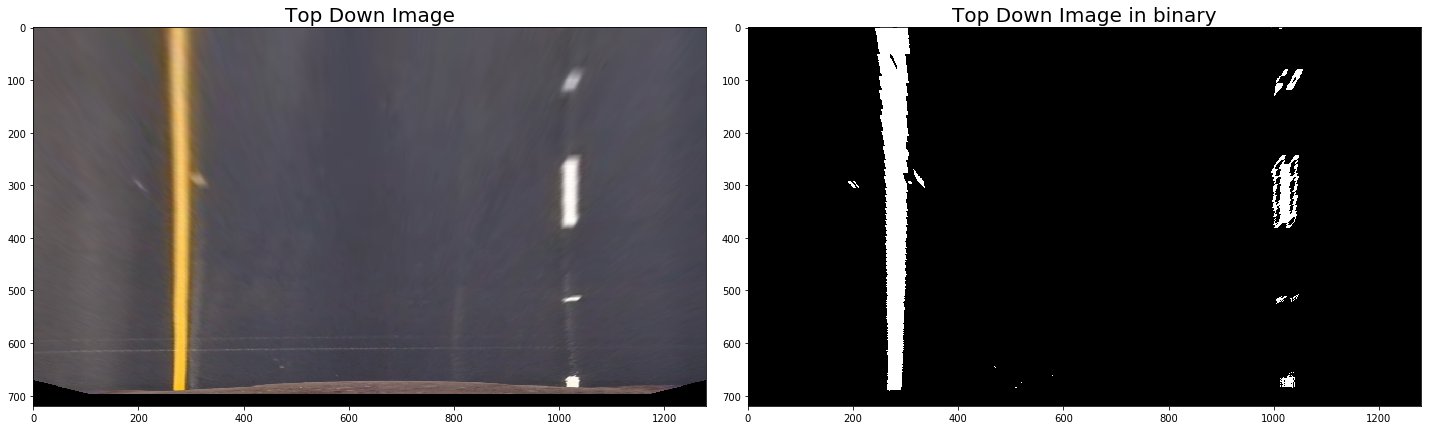

In [5]:
# Input:
#   Original Image
#   4 Source points picked manually that make up the left and right straight lines
#   Binary image with combined channel and gradient thresholding
#   Option to plot the lanes
# Output:
#   List of points of the left & right lines fit by a 2nd order polynomial
#   List of nonzero pixel indicies in x and y within a margin
def perspectiveTransform(img, src, dst, combined_binary, plot=1):      
    # cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # cv2.warpPerspective() to warp the image to a top-down view
    top_down = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    top_down_binary = cv2.warpPerspective(combined_binary, M, (img.shape[1], img.shape[0]))

    if(plot):
        f, (ax2, ax3) = plt.subplots(1, 2, figsize=(20,10))
        f.tight_layout()
        #ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        #ax1.set_title('Original Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(top_down, cv2.COLOR_BGR2RGB))
        ax2.set_title('Top Down Image', fontsize=20)
        ax3.imshow(top_down_binary, cmap='gray')
        ax3.set_title('Top Down Image in binary', fontsize=20)

    return top_down, top_down_binary

# Manually pick 4 source points using the straight_lines1 image here
src = np.float32([[560,475],[725, 475],[275, 670],[1025, 670]])
# Define 4 destination points 
dst = np.float32([[275,100],[1025,100],[275, 670],[1025, 670]])  
top_down, top_down_binary = perspectiveTransform(img, src, dst, combined_binary)

## Check this on the 2nd straight test image using the same points from the first image

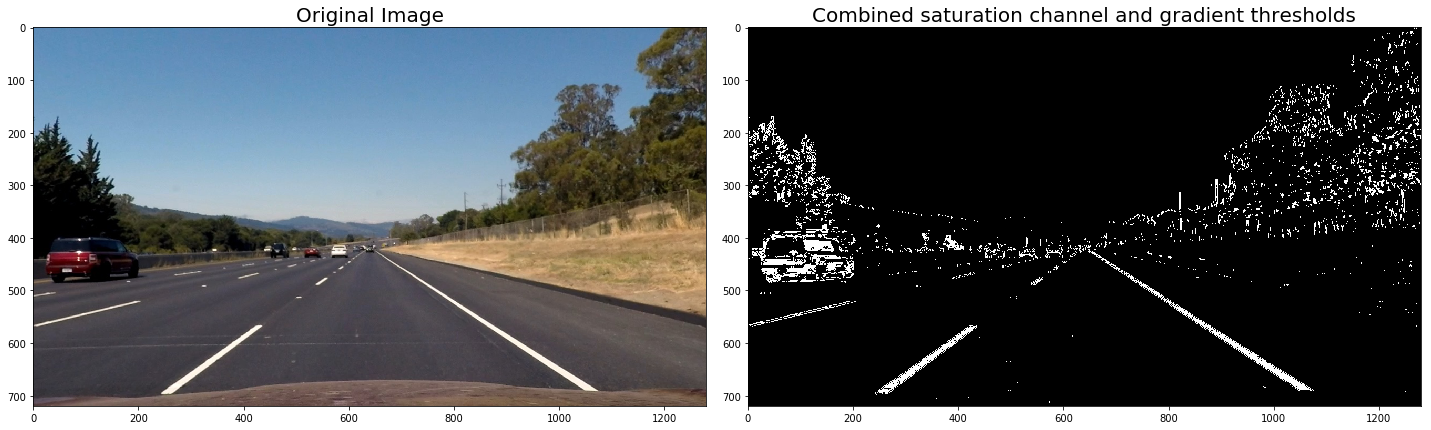

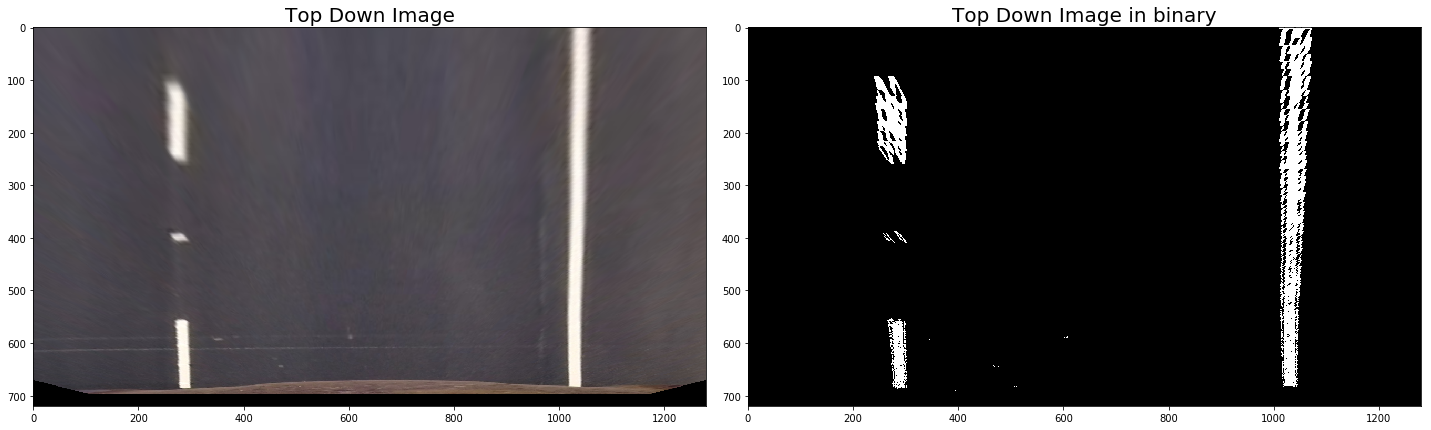

In [6]:
img, combined_binary = gradientThreshold('test_images/straight_lines2.jpg')
top_down, top_down_binary = perspectiveTransform(img, src, dst, combined_binary)


## Detect lane pixels by histogram and find peaks

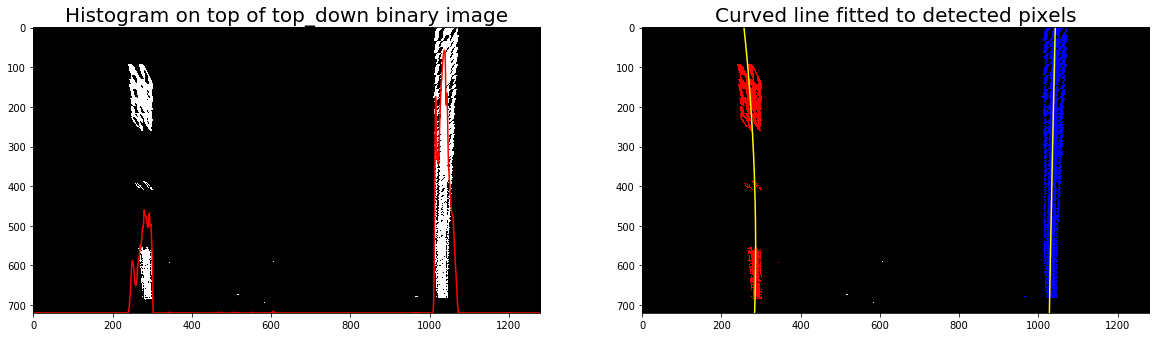

In [7]:
# Input:
#   Top down binary image 
#   Option to plot the lanes
# Output:
#   List of points of the left & right lines fit by a 2nd order polynomial
#   Debug image
def detectLanes(top_down_binary, plot=1):
    histogram = np.sum(top_down_binary, axis=0)
 
    out_img = np.dstack((top_down_binary, top_down_binary, top_down_binary))*255

    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 8
    # Set height of windows
    window_height = np.int(top_down_binary.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = top_down_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 10
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = top_down_binary.shape[0] - (window+1)*window_height
        win_y_high = top_down_binary.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        #decrease margin as you move through the windows
        margin -= 1

            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit_poly = np.polyfit(lefty, leftx, 2)
    right_fit_poly = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, top_down_binary.shape[0]-1, top_down_binary.shape[0] )
    left_fitx = left_fit_poly[0]*ploty**2 + left_fit_poly[1]*ploty + left_fit_poly[2]
    right_fitx = right_fit_poly[0]*ploty**2 + right_fit_poly[1]*ploty + right_fit_poly[2]
    
    #show nonzero pixels in red for left lane and blue for right lane
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    if(plot):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

        ax1.set_title('Histogram on top of top_down binary image', fontsize=20)
        ax1.plot(top_down_binary.shape[0] - histogram , color='red')
        ax1.imshow(top_down_binary, cmap='gray')

        ax2.imshow(out_img)
        ax2.plot(left_fitx, ploty, color='yellow')
        ax2.plot(right_fitx, ploty, color='yellow')
        ax2.set_title('Curved line fitted to detected pixels', fontsize=20)


    #To create the debug image for merging into the final video clip
    if(debug):
        f = plt.Figure(frameon=False, figsize=(17.78,10))
        ax1 = f.add_axes([0, 0, 1, 1])
        ax1.imshow(out_img)
        ax1.plot(left_fitx, ploty, color='yellow')
        ax1.plot(right_fitx, ploty, color='yellow')   
        plt.close(f)
        plt.axis('off')
        ax1.axis('off')
        f.patch.set_visible(False)
        canvas = FigureCanvas(f) 
        canvas.draw()
        out_img = np.fromstring(f.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        out_img = out_img.reshape(f.canvas.get_width_height()[::-1] + (3,))
    return left_fit_poly, right_fit_poly, out_img


left_fit_poly, right_fit_poly, debug_img = detectLanes(top_down_binary, plot=1)


## For the straight road test image, show the manually picked points and draw lines on the original image. Draw lines on the top down view image corresponding to the detected lines.

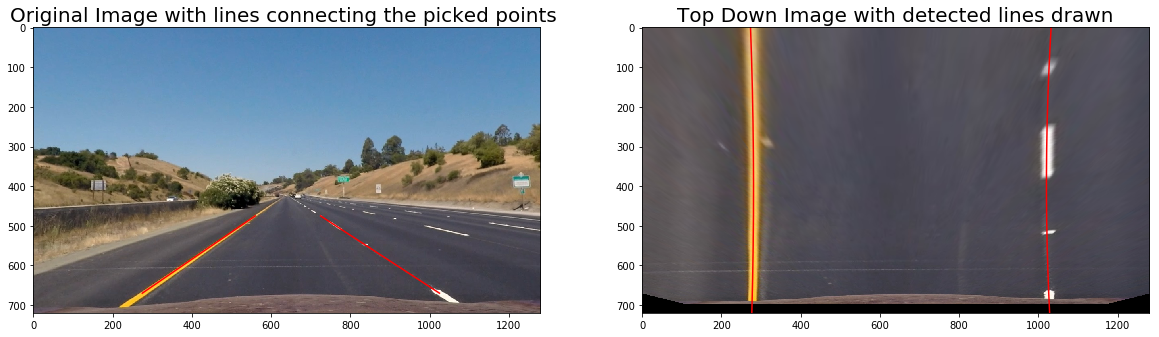

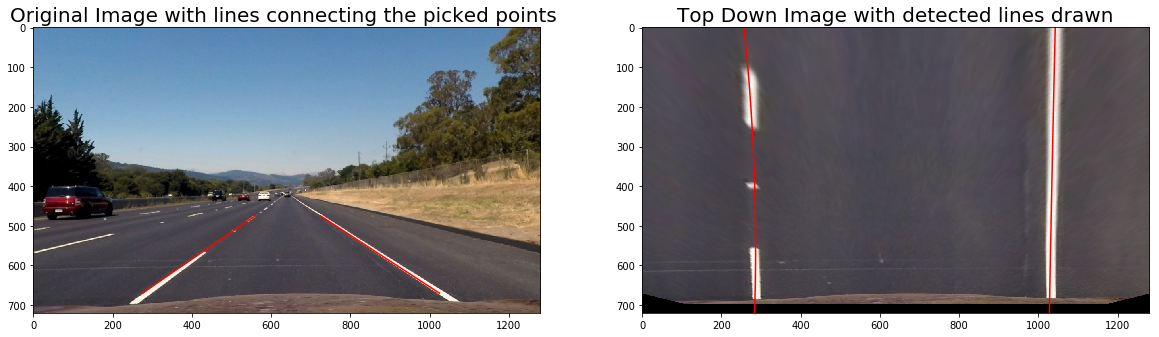

In [8]:
# Input:
#   Top down image
#   polynomial coefficients of detected lines
#   Option to plot manually picked points for the straight lines
# Output:
#   Plot the manually picked points connected by lines on the original image 
#   Plot the detected lines on a top-down image 
def plotLines(top_down, top_down_binary, left_fit_poly, right_fit_poly, straightLines=1):
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, top_down_binary.shape[0]-1, top_down_binary.shape[0] )
    left_fitx = left_fit_poly[0]*ploty**2 + left_fit_poly[1]*ploty + left_fit_poly[2]
    right_fitx = right_fit_poly[0]*ploty**2 + right_fit_poly[1]*ploty + right_fit_poly[2]
    
    if(straightLines):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image with lines connecting the picked points ', fontsize=20)
        ax1.plot([src[0][0], src[2][0]],[src[0][1],src[2][1]], color='red')
        ax1.plot([src[1][0], src[3][0]],[src[1][1],src[3][1]], color='red')
    else:
        f, (ax2) = plt.subplots(1, 1, figsize=(20,10))
        
    ax2.imshow(cv2.cvtColor(top_down, cv2.COLOR_BGR2RGB))
    ax2.plot(left_fitx, ploty, color='red')
    ax2.plot(right_fitx, ploty, color='red')
    ax2.set_title('Top Down Image with detected lines drawn', fontsize=20)
    
# Check the detected lines on a straight road image
img, combined_binary = gradientThreshold('test_images/straight_lines1.jpg', plot=0)
top_down, top_down_binary = perspectiveTransform(img, src, dst, combined_binary, plot=0)
left_fit_poly, right_fit_poly, debug_image = detectLanes(top_down_binary, plot=0)
plotLines(top_down, top_down_binary, left_fit_poly, right_fit_poly, straightLines=1)

img, combined_binary = gradientThreshold('test_images/straight_lines2.jpg', plot=0)
top_down, top_down_binary = perspectiveTransform(img, src, dst, combined_binary, plot=0)
left_fit_poly, right_fit_poly, debug_image = detectLanes(top_down_binary, plot=0)
plotLines(top_down, top_down_binary, left_fit_poly, right_fit_poly, straightLines=1)

## For the non-straight test images, check the fit of the line

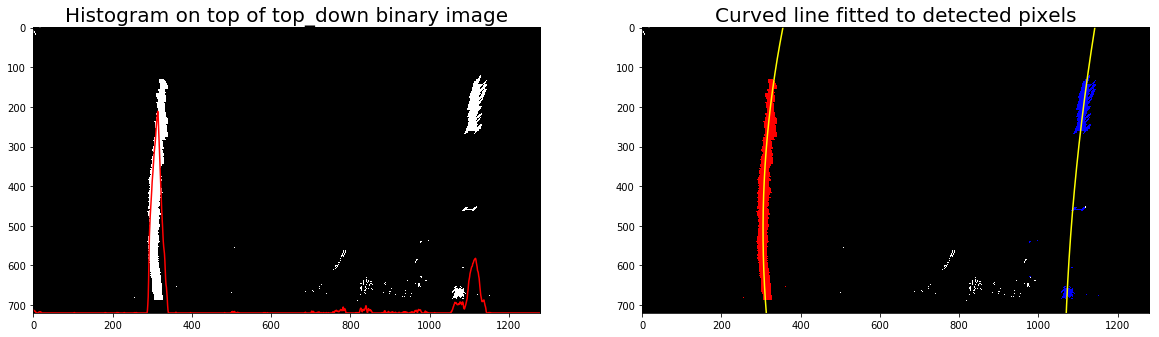

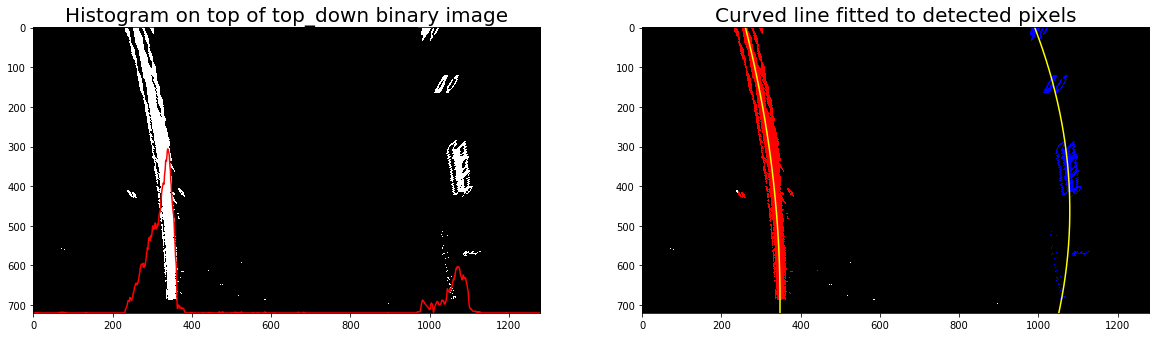

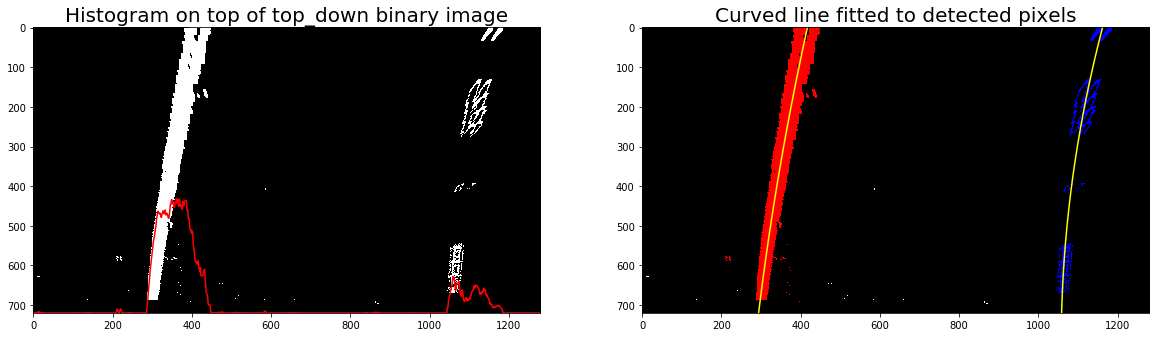

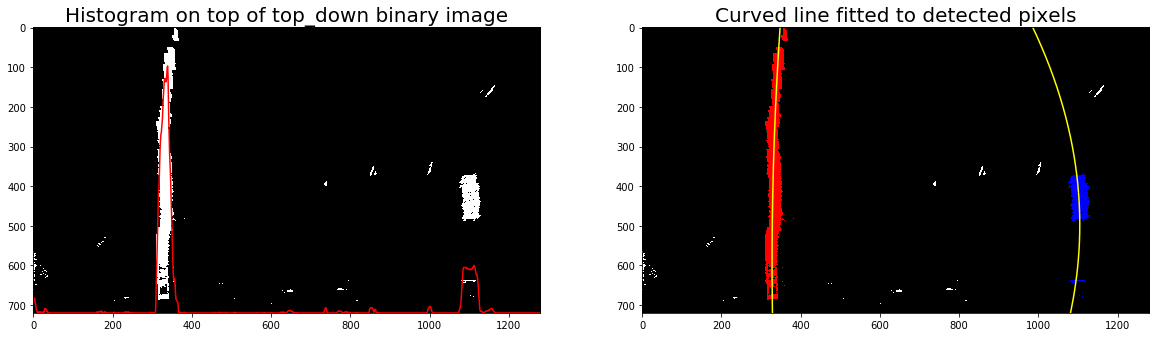

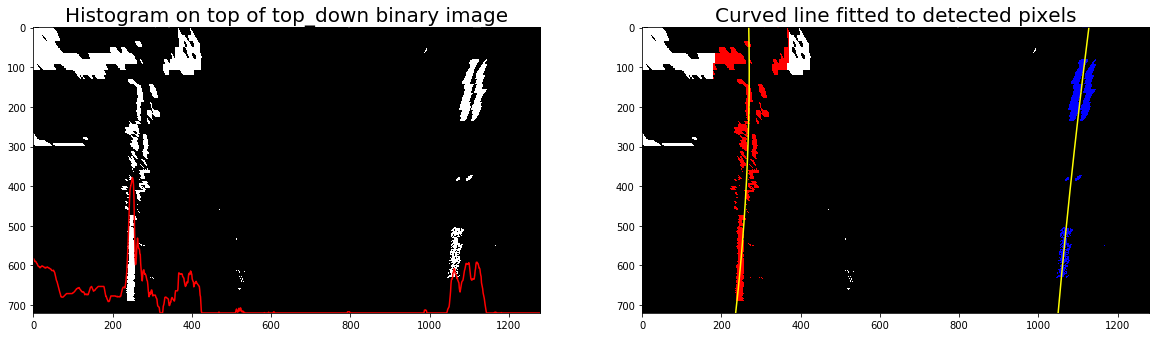

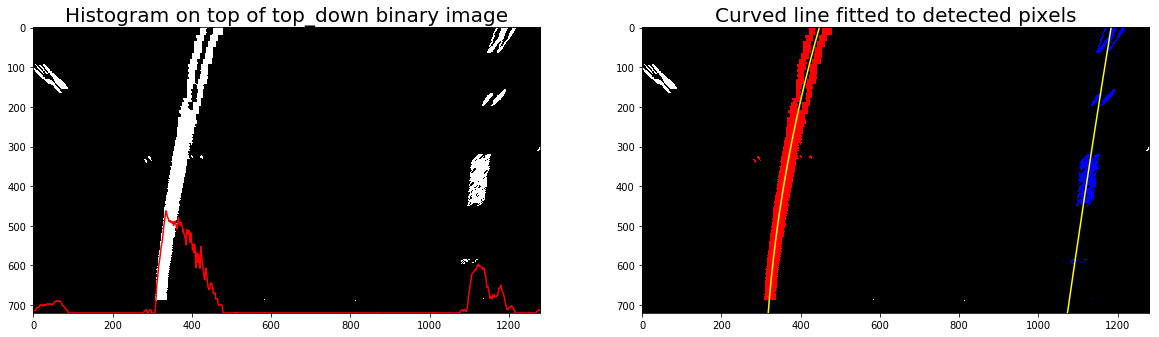

In [9]:

# Make a list of calibration images
images = glob.glob('test_images/test*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img, combined_binary = gradientThreshold(fname, plot=0)
    top_down, top_down_binary = perspectiveTransform(img, src, dst, combined_binary, plot=0)
    left_fit_poly, right_fit_poly, debug_image = detectLanes(top_down_binary, plot=1)



## Determine the curvature of the lane and vehicle position with respect to center. Also show this on a curved image. 

In [10]:
# Input:
#   Top down image
#   Polynomial coefficients of the detected lines
# Output:
#   Left and right curvature values in meters
#   Center curvature value is the average of left and right values

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def getCurvature(top_down, left_fit_poly, right_fit_poly, printResult=1):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    # Generate x and y values for plotting
    ploty = np.linspace(0, top_down_binary.shape[0]-1, top_down_binary.shape[0] )
    left_fitx = left_fit_poly[0]*ploty**2 + left_fit_poly[1]*ploty + left_fit_poly[2]
    right_fitx = right_fit_poly[0]*ploty**2 + right_fit_poly[1]*ploty + right_fit_poly[2]
 
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fitx[0]*y_eval + left_fitx[1])**2)**1.5) / np.absolute(2*left_fitx[0])
    right_curverad = ((1 + (2*right_fitx[0]*y_eval + right_fitx[1])**2)**1.5) / np.absolute(2*right_fitx[0])

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    center_curverad = (left_curverad + right_curverad)/2
    # Now our radius of curvature is in meters
    if(printResult):
        print(left_curverad, 'm', right_curverad, 'm', center_curverad)
    return left_curverad, right_curverad, center_curverad
    
img, combined_binary = gradientThreshold('test_images/test1.jpg', plot=0)
top_down, top_down_binary = perspectiveTransform(img, src, dst, combined_binary, plot=0)
left_fit_poly, right_fit_poly, debug_image = detectLanes(top_down_binary, plot=0)    
left_curverad, right_curverad, center_curverad = getCurvature(top_down, left_fit_poly, right_fit_poly)

860.559885407 m 1989.80571321 m 1425.18279931


## Determine offset from center of lane based on the points on the left and right lines on the bottom of the image. The camera is assumed to be at the center of the car.

In [11]:
# getCenterOffset - Get the offset to the center of the lane from the center of the camera
# Input:
#   X & Y values for the bottom most points
#   Image length (x direction)
# Output:
#   Offset value in meters 
def getCenterOffset(leftx, rightx, img_shapex):
    lane_diff = rightx - leftx
    camera_center = img_shapex/2
    lane_center = leftx+ lane_diff/2    
    return (camera_center - lane_center)*xm_per_pix



## Show the detected lane over original image.

890.984387815 m 395.750971788 m 643.367679801


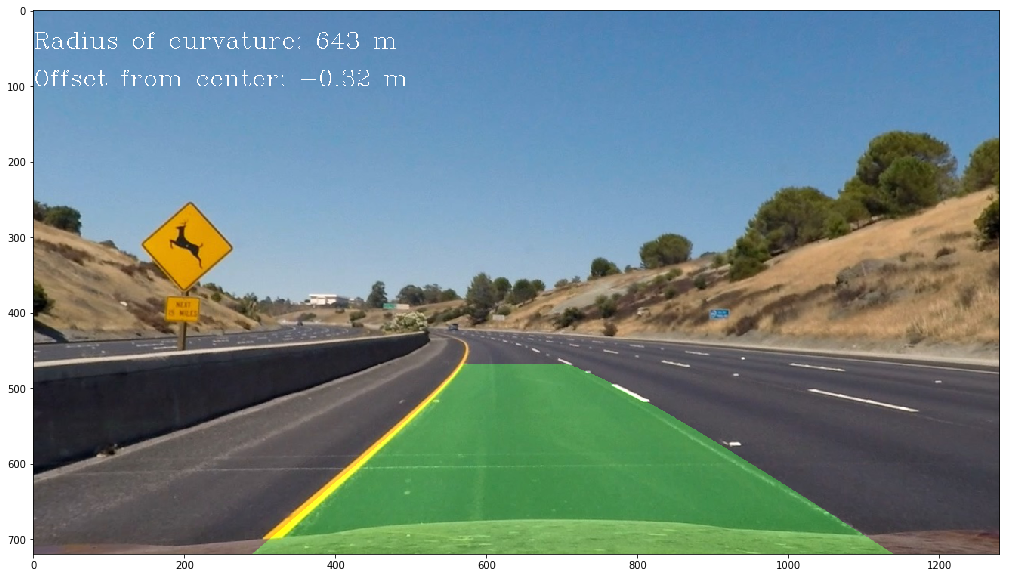

In [12]:
# showLane - Shows the detected lane over the original image.
# Input:
#   Top down image
#   Polynomial coefficients of the detected lines
#   Original source and destination points for the warp transformation
#   Radius of curvature for left and right lines. Also the center curvature. 
#   Option to plot the lanes
# Output:
#   Left and right curvature values in meters
#   Offset from center
def getLane(img, top_down_binary, left_fit_poly, right_fit_poly, src, dst, left_curverad, right_curverad, center_curverad, plot=1):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(top_down_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
             
    # Generate x and y values for plotting
    ploty = np.linspace(0, top_down_binary.shape[0]-1, top_down_binary.shape[0] )
    left_fitx = left_fit_poly[0]*ploty**2 + left_fit_poly[1]*ploty + left_fit_poly[2]
    right_fitx = right_fit_poly[0]*ploty**2 + right_fit_poly[1]*ploty + right_fit_poly[2]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])    
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank image back to original image space using inverse perspective matrix (M)
    M = cv2.getPerspectiveTransform(dst,src)
    newwarp = cv2.warpPerspective(color_warp, M, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 1, newwarp, 0.3, 0)

    #Add text
    center = getCenterOffset(left_fitx[img.shape[0]-1], right_fitx[img.shape[0]-1], img.shape[1])
    text = 'Radius of curvature: {0:.0f} m'.format(center_curverad)
    result = cv2.putText(result, text, org=(0,50), fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=1, color=(255,255,255))
    text = 'Offset from center: {0:.2f} m'.format(center) 
    result = cv2.putText(result, text, org=(0,100), fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=1, color=(255,255,255))
    #text = 'R Coefficients: {0:.2f} {1:.2f} {2:.2f}'.format(right_fit_poly[0], right_fit_poly[1], right_fit_poly[2])
    #result = cv2.putText(result, text, org=(0,200), fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=1, color=(255,255,255))
    #text = 'L Coefficients: {0:.2f} {1:.2f} {2:.2f}'.format(left_fit_poly[0], left_fit_poly[1], left_fit_poly[2])
    #result = cv2.putText(result, text, org=(0,250), fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=1, color=(255,255,255))
    if(plot):
        f, (ax1) = plt.subplots(1, 1, figsize=(20,10))
        ax1.imshow(result)

    return result, center
           
img, combined_binary = gradientThreshold('test_images/test2.jpg', plot=0)
top_down, top_down_binary = perspectiveTransform(img, src, dst, combined_binary, plot=0)
left_fit_poly, right_fit_poly, debug_image = detectLanes(top_down_binary, plot=0) 
left_curverad, right_curverad, center_curverad = getCurvature(top_down, left_fit_poly, right_fit_poly)

result, center = getLane(img, top_down_binary, left_fit_poly, right_fit_poly, src, dst, left_curverad, right_curverad, center_curverad)

## Keep coefficients polynomials for n=5 frames and also check the validity of coefficients

In [13]:
# storePoly - Keeps n frames of polynomial coefficients
# Input:
#   Polynomial coefficients of the detected lines
#   Central curvature value
#   Current debug image
# Output:
#   Left and right polynomial coefficients 
left_polys = []
right_polys = []
prev_imgs = []
n_frames = 5
prev_curves = []

def storePoly(left_fit_poly, right_fit_poly, center_curverad, curr_img):
    if(len(left_polys) == n_frames and not left_polys):
        prev_imgs.pop(0)
        prev_curves.pop(0)
        left_polys.pop(0)
    if(len(right_polys) == n_frames and not right_polys):
        right_polys.pop(0)
    left_polys.append(left_fit_poly)
    right_polys.append(right_fit_poly)
    prev_imgs.append(curr_img)
    prev_curves.append(center_curverad)

In [14]:
# checkCurves - check the polynomials to see if the derivative is in a certain range of each other. If they are out of bounds, take the last set of good coefficients
# Input:
#   Polynomial coefficients of the detected lines
#   Current debug image
# Output:
#   Left and right polynomial coefficients
#   Debug image
max_poly_change = 0.60
max_curve_change = 50000

def checkCurves(left_fit_poly, right_fit_poly, curr_img):
    bottom = img_size[1]
    mid = bottom/2
    top = 0
    derivative_f = lambda x: np.abs(2*left_fit_poly[0]*x+left_fit_poly[1] - 2*right_fit_poly[0]*x+right_fit_poly[1])
    
    
    if(left_polys and right_polys):
        if(derivative_f(top) > max_poly_change or 
           derivative_f(bottom) > max_poly_change or
           derivative_f(mid) > max_poly_change):
            #print("measurement is off - revert to previous")
            left_fit_poly = left_polys[-1]
            right_fit_poly = right_polys[-1]
            curr_img = prev_imgs[-1]
      
    return left_fit_poly, right_fit_poly, curr_img

## Code for processing the video

In [15]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:

def process_image(image):
    global nframe_count

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  #convert from RGB to BGR
    img, combined_binary = gradientThreshold(image, plot=0, isFile=0)
    top_down, top_down_binary = perspectiveTransform(img, src, dst, combined_binary, plot=0)
    left_fit_poly, right_fit_poly, debug_img = detectLanes(top_down_binary, plot=0)    
    left_curverad, right_curverad, center_curverad = getCurvature(top_down, left_fit_poly, right_fit_poly, printResult=0)
    left_fit_poly, right_fit_poly, debug_img = checkCurves(left_fit_poly, right_fit_poly, debug_img)
    storePoly(left_fit_poly, right_fit_poly, center_curverad, debug_img)
    result, center = getLane(img, top_down_binary, left_fit_poly, right_fit_poly, src, dst, left_curverad, right_curverad, center_curverad, plot=0)
    if(debug):
        result = np.concatenate((result, debug_img), axis=1)
    return result

In [17]:

output = 'output.mp4'
input1 = VideoFileClip("project_video.mp4")

clip = input1.fl_image(process_image) 
%time clip.write_videofile(output, audio=False)



[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [02:24<00:00,  8.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 14min 27s, sys: 3.99 s, total: 14min 31s
Wall time: 2min 24s
